# Задача 2. Определение стоимости авто #

Ключевая метрика RMSE -  среднеквадратичная ошибка. Чтобы сдать проект значение метрики должно быть не более 2500.

# Импортируем необходимые библиотеки 

In [20]:
import pandas as pd

# Подготовка данных #

Откроем и изучим файл

In [21]:
df = pd.read_csv("autos.csv")

In [22]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проверим типы данных

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Создание описательной статистики

In [24]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Удаление неиформативных признаков и изменение названий столбцов

удалим неинформативные признаки

In [29]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 
                  'NumberOfPictures','PostalCode', 'LastSeen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


Работа со стилем и типами данных

изменим названия столбцов

In [30]:
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 
                'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'date_created']

изменим тип данных в столбцах, где это необходимо

In [31]:
df['date_created'] = pd.to_datetime(df['date_created'])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              354369 non-null  int64         
 1   vehicle_type       316879 non-null  object        
 2   registration_year  354369 non-null  int64         
 3   gearbox            334536 non-null  object        
 4   power              354369 non-null  int64         
 5   model              334664 non-null  object        
 6   kilometer          354369 non-null  int64         
 7   fuel_type          321474 non-null  object        
 8   brand              354369 non-null  object        
 9   repaired           354369 non-null  object        
 10  date_created       354369 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 29.7+ MB


Работа с пропусками

функция для построения графика, отражающего доли пропусков

In [34]:
def pass_value_barh(df):
    if df.isna().sum().sum() > 0:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(10, 8), legend = False, fontsize = 12)
            .set_title('Доля пропусков' + "\n", fontsize = 14)    
        )   
    else:
        print('Пропусков не осталось!')

визуализация доли пропусков в каждом столбце

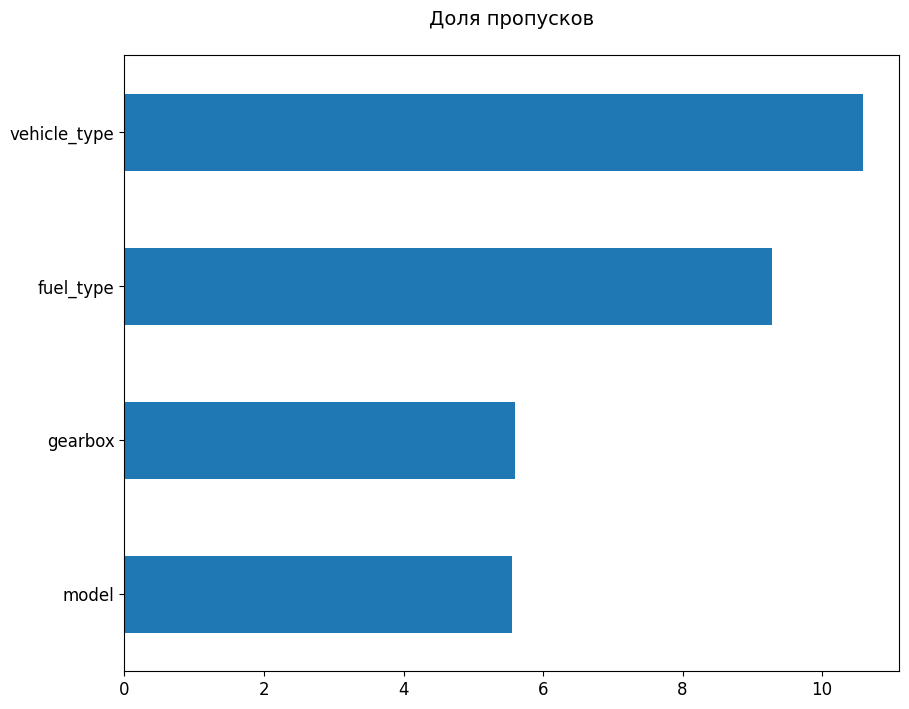

In [35]:
pass_value_barh(df)

заполним пропуски и заменим значения в столбце "repaired"

In [36]:
df['repaired'] = df['repaired'].fillna('no')
df.loc[(df.repaired == 'no'), 'repaired'] = 0
df.loc[(df.repaired == 'yes'), 'repaired'] = 1

In [37]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,0,2016-03-24
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,1,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0,2016-03-31


заполним пропуски в других столбцах

In [38]:
df = df.fillna('unknown')

In [40]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,0,2016-03-24
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,1,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0,2016-03-31


проверяем, что пропусков не осталось

In [41]:
pass_value_barh(df)

Пропусков не осталось!


В столбце, который показывает была ли машина в ремонте, заменим все пустые значения на "no". Так можно поступить, так как при заполнении данного признак, если машина не ремонтировалась, графу могли отставлять пустой. Затем поменяем значения "yes" на 1, а "no" на 0.

Все остальные столбцы с пропусками отражают категориальные признаки: тип автомобильного кузова, тип топлива, тип коробки передач, модель автомобиля. Заполним эти пропуски значением "unknown".